In [0]:
!pip install fastai2 -q

In [0]:
from fastai2.vision.all import *

In [0]:
from fastai2.basics import *

In [0]:
path=Path('/content/drive/My Drive/face_age')

In [0]:
path.ls()

(#59) [Path('/content/drive/My Drive/face_age/069'),Path('/content/drive/My Drive/face_age/068'),Path('/content/drive/My Drive/face_age/062'),Path('/content/drive/My Drive/face_age/066'),Path('/content/drive/My Drive/face_age/061'),Path('/content/drive/My Drive/face_age/064'),Path('/content/drive/My Drive/face_age/063'),Path('/content/drive/My Drive/face_age/065'),Path('/content/drive/My Drive/face_age/060'),Path('/content/drive/My Drive/face_age/067')...]

In [0]:
def to_num(x:str): return int(x)

In [0]:
get_y= Pipeline([parent_label,to_num])

In [0]:
dblock=DataBlock(blocks=[ImageBlock,RegressionBlock()],
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=get_y,
                 item_tfms=Resize(240, method='squish'),
                batch_tfms=[*aug_transforms(size=224, max_warp=0, max_rotate=7.0, max_zoom=1.0)]
                 )

In [0]:
dls=dblock.dataloaders(path,bs=64,verbose=True)

Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm


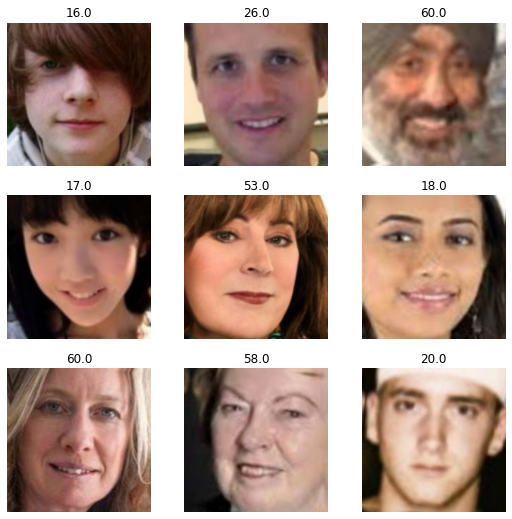

In [0]:
dls.show_batch()

In [0]:
dls.c

1

In [0]:
learn=cnn_learner(dls,resnet18,loss_func=MSELossFlat(), y_range=(10.0,70.0))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
learn.fit_one_cycle(5,0.0055)

epoch,train_loss,valid_loss,time
0,418.010986,391.286804,26:17
1,232.212097,124.329254,00:37
2,141.928299,101.855194,00:38
3,106.818748,94.406532,00:38
4,86.828590,93.503677,00:38


In [0]:
fnames=get_image_files(path/'050')

In [0]:
pred,_,_=learn.predict(fnames[11]);pred

(50.820945739746094)

Customizing lil bit...

In [0]:
body=create_body(resnet18, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
nf=num_features_model(nn.Sequential(*body.children())) *(2) ; nf

1024

In [0]:
head=create_head(nf,dls.c, y_range=(0,100))

In [0]:
model=nn.Sequential(body,head)

In [0]:
apply_init(model[1], nn.init.kaiming_normal_)

In [0]:
def _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)

Using ranger optimizer

In [0]:
learn=Learner(dls,model, loss_func=MSELossFlat(),splitter=_resnet_split, opt_func=ranger)

In [0]:
learn.opt_func

<function fastai2.optimizer.ranger>

In [0]:
learn.freeze()

In [0]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  864        False     
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      False     
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     False     
_________________________________________________

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=3.981071586167673e-06)

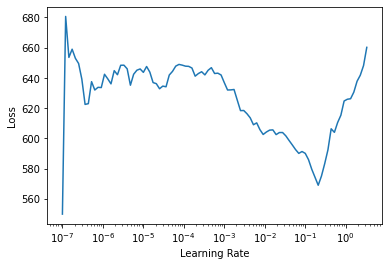

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(5,0.055)


epoch,train_loss,valid_loss,time
0,144.610977,504.381134,00:25
1,150.061020,116.044441,00:25
2,130.627716,244.775742,00:24
3,109.904083,90.760544,00:24
4,96.741592,86.226562,00:24


In [0]:
fnames=get_image_files(path/'025')

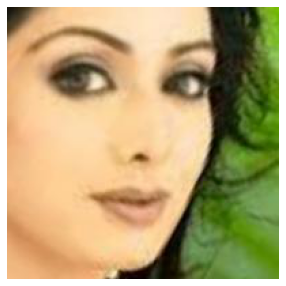

In [0]:
img=PILImage.create(fnames[10])
img.show()

In [0]:
pred,_,_=learn.predict(fnames[10]);pred

(25.316184997558594)

arch-xresnet18 , activation func-Mish, optimizer- ranger and self-attention

In [0]:
#from fastai2 repo
def create_custom_body(arch, n_in=3, pretrained=True,act_cls=nn.ReLU(),sa=False, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained,act_cls=act_cls,sa=sa)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

In [0]:
body=create_custom_body(xresnet18, pretrained=True, act_cls=Mish, sa=True)

In [0]:
body

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [0]:
nf=num_features_model(nn.Sequential(*body.children())) * 2; nf

1024

In [0]:
head=create_head(nf,dls.c, y_range=(0,100))

In [0]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=False)
  (9): SigmoidRange(low=0, high=100)
)

In [0]:
model=nn.Sequential(body, head)

In [0]:
len(model)

2

In [0]:
apply_init(model[1], nn.init.kaiming_normal_)

In [0]:
def _xresnet_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)

In [0]:
learn=Learner(dls, model, loss_func=MSELossFlat(), splitter=_xresnet_split, opt_func=ranger)

In [0]:
learn.freeze()

In [0]:
learn.opt_func

<function fastai2.optimizer.ranger>

In [0]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  864        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
Mish                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
Mish                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     True      
_________________________________________________

In [0]:
learn.fit_one_cycle(5,0.0045)

epoch,train_loss,valid_loss,time
0,96.813683,108.744286,00:28
1,100.772240,148.933426,00:28
2,104.659592,116.100792,00:28
3,90.135223,79.807816,00:28
4,81.242439,76.847153,00:27


In [0]:
learn.save('stage3')

In [0]:
fnames=get_image_files(path/'030')

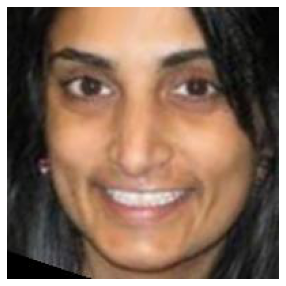

In [0]:
img=PILImage.create(fnames[27])
img.show()

In [0]:
pred,_,_=learn.predict(fnames[27]);pred

(30.498722076416016)